# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos Agonistas de la Hormona GLP-1**

### Avance 3: Base Line Modelo Predictivo

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dra. Eduviges Ludivina Facundo Flores  – Profesor Tutor

### **Asesores**
- Dr. Juan Arturo Nolazco Flores
- Dr. Carlos Alberto Brizuela Rodríguez

#### **Miembros del equipo:**
- Cesar Ivan Herrera Martinez A01796392  
- Juan Antonio Cruz Acosta A01795375 
- Julio Baltazar Colín A01794476 

# Modelo Predictivo

## Introducción: 


### Carga de los datos procesados

In [1]:
# Carga de archivos y librerias basicas

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional
import sys
import os
import pycaret
from pycaret.regression import *
from pycaret.utils import *

# Rutas locales a Bibliotecas y utilerias
from pathlib import Path

# ruta del directorio del notebook actual
notebook_dir = Path.cwd()

# Subir un nivel para llegar a la carpeta raíz del proyecto
project_root = notebook_dir.parent

# Añadir la carpeta raíz al path de Python
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"Ruta del proyecto añadida al path: {project_root}")

from src.plotting import plot_pca_3d

Ruta del proyecto añadida al path: d:\source\Proyecto Integrador\glp-1_drug_discovery


In [2]:
# Establecer la ruta los archivos de datos
directorio_base = Path("../")
directorio_datos = Path(directorio_base / "data")
directorio_modelos = Path(directorio_base / "models")
directorio_modelos_automl= Path(directorio_modelos / "pycaret")
raw_data_dir = directorio_datos / "raw"
processed_data_dir = directorio_datos / "processed"

# --- Rutas de Archivos de Datos ---
# Datos con actividad conocida (para entrenamiento)
ruta_125_ec50 = processed_data_dir / "descriptores_125.csv"

# Datos sin actividad conocida (para predicción)
ruta_peptidos_eval = processed_data_dir / "descriptores_cdhit.csv"


# Ruta archivo con péptidos con actividad EC50 filtrado con 20 descriptores de entropia
ruta_125_ent= processed_data_dir / "descriptores_Spearman.csv"

# --- Rutas para Modelos CON PCA ---
ruta_dir_modelos = directorio_modelos_automl / "modelos_GLP1_pca"
ruta_top_modelos = ruta_dir_modelos / "top_modelos_GLP1"
ruta_modelo_stack = ruta_dir_modelos / "modelo_GLP1_stack"
ruta_modelo_blend = ruta_dir_modelos / "modelo_GLP1_blend"
ruta_pipeline = ruta_dir_modelos / "pipeline_modelo_GLP1"
ruta_mejor_modelo = ruta_dir_modelos / "mejor_modelo"
ruta_mejor_modelo_final = ruta_dir_modelos / "mejor_modelo_final"
ruta_experimento = ruta_dir_modelos / "experimento_GLP1"
ruta_resultados_prediccion = directorio_datos / "Predicciones_Peptidos_PCA_GLP1.csv"


os.makedirs(ruta_dir_modelos, exist_ok=True)

In [3]:
# Carga de datos para predicción
df_entrenamiento = pd.read_csv(ruta_125_ec50)
df_entrenamiento.set_index('ID', inplace=True)
df_entrenamiento.columns = df_entrenamiento.columns.str.replace('.', '_', regex=False)

df_Entropia = pd.read_csv(ruta_125_ent)
df_Entropia.set_index('ID', inplace=True)
df_Entropia.columns = df_Entropia.columns.str.replace('.', '_', regex=False)

df_desconocidos = pd.read_csv(ruta_peptidos_eval)
df_desconocidos.set_index('ID', inplace=True)
df_desconocidos.columns = df_desconocidos.columns.str.replace('.', '_', regex=False)

### Calculo de pEC50 como columna objetivo

A find de facilitar la interpretacion de los resultados, se transforma la variable objetivo EC50 a pEC50, que es su logaritmo negativo en base 10. Esto convierte valores pequeños de EC50 (alta potencia) en valores grandes de pEC50, facilitando la comparación y análisis.
Esto es especialmente útil en bioquímica y farmacología, donde se trabaja con rangos amplios de concentraciones, ademas de que los valores de pEC50 son más intuitivos para interpretar la eficacia de los compuestos y permite a los modelos de machine learning capturar mejor las relaciones no lineales en los datos.
Trabajar direcatamente con EC50 puede ser problemático debido a su amplia gama y distribución sesgada, mientras que pEC50 tiende a tener una distribución más normalizada, lo que mejora el rendimiento de los modelos predictivos.

In [4]:
# Transformación de EC50_T2 a pEC50 positivo como columna objetivo
df_entrenamiento['pEC50'] = -np.log10(df_entrenamiento["EC50_T2"] * 1e-12)

In [5]:
print("Datos de entrenamiento cargados y procesados:")
display(df_entrenamiento.tail(3))

Datos de entrenamiento cargados y procesados:


,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,Moran_BHAR880101_lag2,Moran_BHAR880101_lag3,GAAC_alphatic,GAAC_aromatic,GAAC_postivecharge,GAAC_negativecharge,GAAC_uncharge,EC50_T2,EC50_LOG_T2,pEC50
ID,,,,,,,,,,,,,,,,,,,,,
seq_pep123,0.033333,0.0,0.066667,0.100000,0.066667,0.100000,0.033333,0.033333,0.033333,0.066667,...,-0.113437,-0.117154,0.300000,0.133333,0.100000,0.166667,0.300000,29500.0,-7.53,7.530178
seq_pep124,0.033333,0.0,0.066667,0.066667,0.100000,0.100000,0.033333,0.000000,0.033333,0.133333,...,-0.012070,0.012804,0.366667,0.166667,0.100000,0.133333,0.233333,598.0,-9.22,9.223299
seq_pep125,0.000000,0.0,0.103448,0.103448,0.103448,0.103448,0.034483,0.000000,0.034483,0.172414,...,0.005384,-0.108561,0.344828,0.137931,0.068966,0.206897,0.241379,30200.0,-7.52,7.519993


In [6]:
print("\nDatos para predicción cargados:")
display(df_desconocidos.tail(3))


Datos para predicción cargados:


,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,Moran_BEGF750103_lag2,Moran_BEGF750103_lag3,Moran_BHAR880101_lag1,Moran_BHAR880101_lag2,Moran_BHAR880101_lag3,GAAC_alphatic,GAAC_aromatic,GAAC_postivecharge,GAAC_negativecharge,GAAC_uncharge
ID,,,,,,,,,,,,,,,,,,,,,
XP_029460758.1,0.100000,0.0,0.033333,0.166667,0.033333,0.100000,0.033333,0.033333,0.066667,0.066667,...,-0.410344,0.116491,0.305043,-0.329691,-0.089598,0.366667,0.133333,0.100000,0.200000,0.200000
XP_030211526.1,0.166667,0.0,0.100000,0.066667,0.066667,0.066667,0.033333,0.000000,0.066667,0.066667,...,0.033409,0.059270,0.328924,-0.187628,-0.237194,0.366667,0.133333,0.100000,0.166667,0.233333
XP_031714513.1,0.066667,0.0,0.100000,0.033333,0.033333,0.066667,0.033333,0.000000,0.066667,0.066667,...,-0.172395,0.129458,0.160526,-0.412839,0.001428,0.300000,0.133333,0.133333,0.133333,0.300000


### Ajuste de la Columna objetivo

El primer gráfico muestra la distribución de los valores de EC50_T2. Se puede observar claramente un fuerte sesgo positivo, con la gran mayoría de los datos concentrados en valores bajos y una cola larga hacia la derecha. Este tipo de distribución puede ser problemático para muchos algoritmos de machine learning, que a menudo funcionan mejor con variables objetivo que se aproximan a una distribución normal, en algunos casos tambien resulta problemático trabajar con valores negativos para la variable objetivo.


Para corregir este sesgo, aplicamos una transformación logarítmica negativa para convertir EC50_T2 en pEC50 $$(pEC50 = -log10(EC50))$$ 

Los gráficos segundo y tercero muestran la distribución de la nueva variable pEC50 para dos conjuntos de datos diferentes. Como se puede apreciar, la distribución ahora es mucho más simétrica y se asemeja más a una distribución normal (o bimodal), lo que la convierte en una variable objetivo mucho más adecuada para el entrenamiento de nuestros modelos de regresión.

Text(0.5, 1.0, 'Distribución de pEC50')

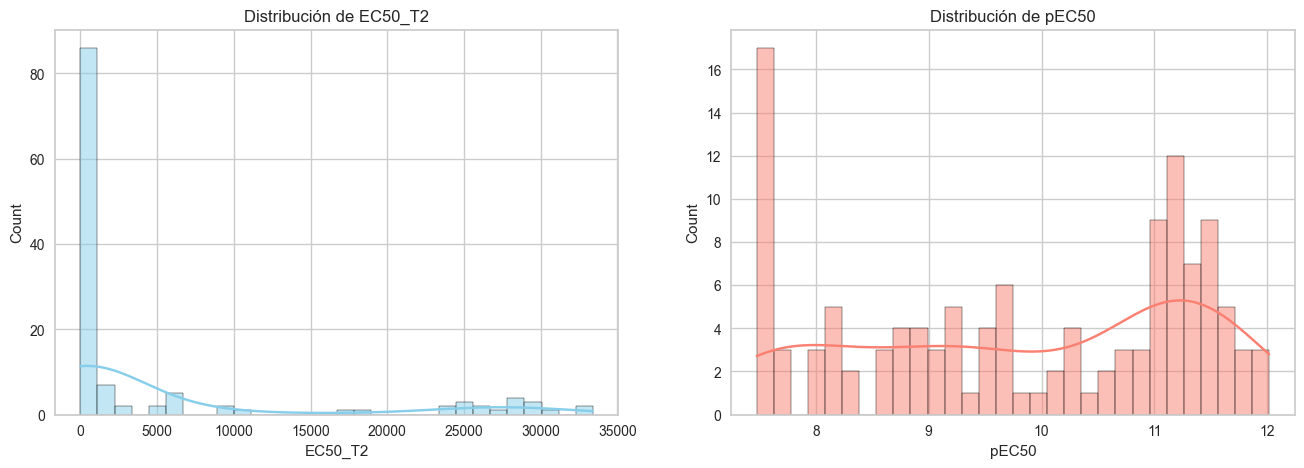

In [7]:
## Grafico de la distribucion de ec50 y pEC50
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1, 2,  figsize=(16, 5))
sns.histplot(df_entrenamiento['EC50_T2'], bins=30, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribución de EC50_T2')
sns.histplot(df_entrenamiento['pEC50'], bins=30, kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Distribución de pEC50') 



## Experimento con todas las características obtenidas de los péptidos

En esta libreta se configura y ejecuta un experimento de regresión utilizando PyCaret para predecir la actividad biológica (pEC50) de péptidos basándose en sus descriptores moleculares.

En este caso no se aplica reducción de dimensionalidad (PCA) y se utilizan todas las características disponibles junto con cross-validation y 10 K-Folds .


Después de ejecutar varias pruebas previas se encontró que esta combinación de parámetros proporcionó buenos resultados

Los parámetros clave de esta configuración son:

```Target='pEC50'```: Se define la columna pEC50 como nuestra variable objetivo a predecir.

```ignore_features``` Se excluyen las columnas EC50_T2 y EC50_LOG_T2 para que no sean consideradas como características predictivas.

```normalize=True``` Se activa la normalización de todas las características numéricas para escalarlas a un rango común, utilizando el método ```maxabs```.

```fold=10``` Se establece una estrategia de validación cruzada de 10 pliegues (K-folds), que es el método estándar para evaluar el rendimiento de los modelos.
```ignore_features```: Se excluyen las columnas EC50_T2 y EC50_LOG_T2 para que no sean consideradas como características predictivas.

```normalize=True```: Se activa la normalización de todas las características numéricas para escalarlas a un rango común, utilizando el método ```maxabs```.

```fold=10``` Se establece una estrategia de validación cruzada de 10 pliegues (K-folds), que es el método estándar para evaluar el rendimiento de los modelos.

In [8]:
# Parámetros globales para PyCaret
ignore_features = ['ID', 'EC50_T2', 'EC50_LOG_T2']
target = 'pEC50'

# Setup sin PCA
experiment = setup(
    data=df_entrenamiento, 
    target='pEC50',                 # columna objetivo
    ignore_features=ignore_features,
    normalize=True,   
    normalize_method='maxabs', 
    session_id=132400,              # simiar al random_state, permite reproducibilidad
    verbose=False,
    experiment_name='GLP1_NO_PCA',
    fold=10,                        # número de folds para cross-validation
    pca=True,
    pca_components=0.99, # o pca_components=0.95 para varianza explicada
)


### Entrenamiento y Selección de los Mejores Modelos
Entrenamos y evaluamos una grupo de modelos de regresión para establecer una línea "base" de rendimiento. Seleccionamos los 3 mejores modelos basados en su $R²$.
ademas se calcularon metricas adicionales como RMSE, MAE, MAPE y RMSLE para tener una visión más completa del rendimiento de los modelos.

PyCaret proporciona una variedad de métricas para evaluar el rendimiento de los modelos de regresión. A continuación, se describen las métricas utilizadas en este experimento:

### Descripción de las métricas
#### Métricas Basadas en Error

Las siguientes métricas miden el error de un modelo; por lo tanto, **un valor más bajo siempre es mejor**. Generalmente, se expresan en la misma unidad que la variable objetivo (a excepción de MAPE).

---

#### MAE (Mean Absolute Error - Error Absoluto Medio)

El **MAE** calcula el promedio de las diferencias absolutas entre los valores reales ($y_i$) y los predichos ($\hat{y}_i$). Mide la magnitud promedio de los errores, sin considerar si son positivos o negativos. Es menos sensible a los valores atípicos (outliers) que el MSE.

* **Significado**: Un MAE de 5 indica que, en promedio, las predicciones del modelo se desvían 5 unidades del valor real.
* **Fórmula**:
    $MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$

---

#### MSE (Mean Squared Error - Error Cuadrático Medio)

El **MSE** calcula el promedio de los errores al cuadrado. Al elevar el error al cuadrado, penaliza más fuertemente los errores grandes. Esto lo hace muy sensible a los outliers.

* **Significado**: Es más difícil de interpretar directamente, ya que las unidades están al cuadrado. Se usa principalmente como función de coste durante el entrenamiento del modelo.
* **Fórmula**:
    $MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

---

#### RMSE (Root Mean Squared Error - Raíz del Error Cuadrático Medio)

El **RMSE** es  la raíz cuadrada del MSE. Su principal ventaja es que devuelve el error a las unidades originales de la variable objetivo, lo que lo hace mucho más fácil de interpretar que el MSE. Al igual que el MSE, penaliza más los errores grandes.

* **Significado**: Un RMSE de 7.5 significa que, en promedio, el modelo se equivoca en 7.5 unidades. Es una de las métricas más populares para evaluar modelos de regresión.
* **Fórmula**:
    $RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$

---

#### RMSLE (Root Mean Squared Logarithmic Error - Raíz del Error Logarítmico Cuadrático Medio)

El **RMSLE** calcula el RMSE sobre el logaritmo de los valores predichos y reales. Es útil cuando no se desea penalizar tanto la diferencia entre valores grandes, sino más bien la relación porcentual. Solo se puede usar si los valores son positivos.

* **Significado**: Mide el error relativo. Por ejemplo, un error de predecir 110 cuando el valor real es 100 se considerará similar a un error de predecir 1100 cuando el valor es 1000. Es robusto frente a outliers.
* **Fórmula**:
    $RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(1 + \hat{y}_i) - \log(1 + y_i))^2}$

---

#### MAPE (Mean Absolute Percentage Error - Error Porcentual Absoluto Medio)

El **MAPE** expresa el error como un porcentaje promedio del valor real. Esto lo hace muy intuitivo y fácil de comunicar a audiencias no técnicas. Sin embargo, tiene un gran inconveniente: no se puede usar si los valores reales ($y_i$) son cero.

* **Significado**: Un MAPE del 15% significa que, en promedio, el error de predicción es del 15% del valor real.
* **Fórmula**:
    $MAPE = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|$

---

### Métrica de Rendimiento

A diferencia de las anteriores, para esta métrica **un valor más alto es mejor**.

#### R² (Coeficiente de Determinación)

**R²**, o R-cuadrado, mide la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. En otras palabras, indica qué tan bien se ajusta el modelo a los datos.

* **Significado**: Su valor va de 0 a 1. Un **R² de 0.85** significa que el modelo es capaz de explicar el **85% de la variabilidad** de los datos. Un valor cercano a 1 indica un buen ajuste, mientras que un valor cercano a 0 indica que el modelo no es mejor que simplemente predecir el promedio de los datos.
* **Fórmula**:
    $R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$
    donde $\bar{y}$ es la media de los valores reales.

---




In [9]:
# Obtener los 3 mejores modelos Basado en R² como métrica principal
# se seleccionan 3 modelos para un posterior tuning y blending/stacking

print("Comparando modelos para seleccionar los 3 mejores...")
best_3_models = experiment.compare_models(sort='R2', n_select=3)

Comparando modelos para seleccionar los 3 mejores...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,0.7508,1.0742,0.9358,0.4900,0.0897,0.0818,0.0660
lr,Linear Regression,0.7518,1.0904,0.9380,0.4839,0.0898,0.0821,0.5830
lar,Least Angle Regression,0.7518,1.0904,0.9380,0.4839,0.0898,0.0821,0.0680
br,Bayesian Ridge,0.7920,1.0965,0.9668,0.4776,0.0927,0.0857,0.0670
huber,Huber Regressor,0.7546,1.1155,0.9454,0.4727,0.0906,0.0824,0.0720
par,Passive Aggressive Regressor,0.7800,1.1118,0.9617,0.4663,0.0926,0.0850,0.0730
knn,K Neighbors Regressor,0.8243,1.2868,1.0707,0.4131,0.1009,0.0885,0.0670
et,Extra Trees Regressor,0.8194,1.2745,1.0581,0.4118,0.1005,0.0874,0.1310
catboost,CatBoost Regressor,0.9571,1.2943,1.0977,0.3965,0.1042,0.1014,1.6780
omp,Orthogonal Matching Pursuit,0.8993,1.3173,1.0913,0.3749,0.1046,0.0965,0.0710


### Análisis de los Mejores Modelos

Al analizar los resultados, se observa que: los modelos basados en ensambles de árboles de decisión son los que obtienen el mejor rendimiento.

Modelos Lineales Simples: Modelos como Lasso (lasso), Elastic Net (en) y Lasso Least Angle Regression (llar) obtuvieron un R² negativo (-0.1500), idéntico al del Dummy Regressor. Un R² negativo significa que el modelo es peor que simplemente predecir el valor promedio de la variable objetivo. Esto indica que estos modelos lineales no lograron capturar la complejidad de las relaciones en los datos.


In [10]:
# Guardar el pipeline del experimento (usando el mejor modelo como referencia)
save_info = experiment.save_model(best_3_models, ruta_pipeline)
if save_info is not None:
    print(f"Modelo guardado en: {save_info[1]}")
else:
    print("No se pudo guardar el modelo.")

print("\nLos 3 mejores modelos son:")
print(best_3_models)

Transformation Pipeline and Model Successfully Saved
Modelo guardado en: ..\models\pycaret\modelos_GLP1_pca\pipeline_modelo_GLP1.pkl

Los 3 mejores modelos son:
[Ridge(random_state=132400), LinearRegression(n_jobs=-1), Lars(random_state=132400)]


### Ajuste Fino (Tuning) de Hiperparámetros
Optimizamos los hiperparámetros de los 3 mejores modelos para intentar mejorar la capacidad predictiva.
En caso de no encontrar mejoras significativas, se emplea el modelo sin ajustar. obtenido previamente, el proceso es automatico.

En las metricas se resalta en amarillo la media de las métricas obtenidas en cross-validation.

In [11]:
# Afinar los mejores modelos sin PCA y guardarlos individualmente
from ray.tune.search.hyperopt import HyperOptSearch

print("----- Ajuste de modelos -----")

# Ajustar los 3 mejores modelos con 50 iteraciones
print("\nAjustando los 3 mejores modelos...")
tuned_best_3 = [experiment.tune_model(model,
                                         n_iter=10,
                                         optimize='R2',
                                         fold=10,
                                         search_library='scikit-optimize',
                                         search_algorithm='bayesian', 
                                         early_stopping=True) for model in best_3_models]

# Guardar los modelos ajustados
print("\nGuardando modelos ajustados...")
for i, model in enumerate(tuned_best_3):
    save_info = experiment.save_model(model, f"{ruta_top_modelos}_{i+1}")
    if save_info is not None:
        print(f"Modelo guardado en: {save_info[1]}")
    else:
        print("No se pudo guardar el modelo.")


----- Ajuste de modelos -----

Ajustando los 3 mejores modelos...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9581,1.9343,1.3908,0.2339,0.1378,0.1144
1,0.8076,0.9575,0.9785,0.6900,0.0888,0.0808
2,0.5893,0.5898,0.7680,0.5735,0.0760,0.0638
3,0.4447,0.2570,0.5069,0.9053,0.0490,0.0480
4,1.7036,3.8424,1.9602,-0.6388,0.1882,0.1954
5,0.5502,0.3818,0.6179,0.7744,0.0576,0.0560
6,0.7571,0.8610,0.9279,0.4396,0.0843,0.0732
7,0.6197,0.5947,0.7712,0.7071,0.0784,0.0717
8,0.8256,0.9540,0.9767,0.3461,0.0901,0.0816


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8899,2.0878,1.4449,0.1730,0.1438,0.1110
1,0.7812,0.8628,0.9289,0.7206,0.0836,0.0776
2,0.5808,0.6053,0.7780,0.5623,0.0783,0.0633
3,0.4089,0.2331,0.4828,0.9141,0.0435,0.0423
4,1.8052,4.2261,2.0557,-0.8025,0.1966,0.2068
5,0.4762,0.3173,0.5633,0.8125,0.0519,0.0484
6,0.6579,0.6889,0.8300,0.5516,0.0751,0.0636
7,0.6553,0.6147,0.7840,0.6973,0.0811,0.0769
8,0.8832,1.0113,1.0056,0.3068,0.0923,0.0869


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8899,2.0878,1.4449,0.1730,0.1438,0.1110
1,0.7812,0.8628,0.9289,0.7206,0.0836,0.0776
2,0.5808,0.6053,0.7780,0.5623,0.0783,0.0633
3,0.4089,0.2331,0.4828,0.9141,0.0435,0.0423
4,1.8052,4.2261,2.0557,-0.8025,0.1966,0.2068
5,0.4762,0.3173,0.5633,0.8125,0.0519,0.0484
6,0.6579,0.6889,0.8300,0.5516,0.0751,0.0636
7,0.6553,0.6147,0.7840,0.6973,0.0811,0.0769
8,0.8832,1.0112,1.0056,0.3068,0.0923,0.0869


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

Guardando modelos ajustados...
Transformation Pipeline and Model Successfully Saved
Modelo guardado en: ..\models\pycaret\modelos_GLP1_pca\top_modelos_GLP1_1.pkl
Transformation Pipeline and Model Successfully Saved
Modelo guardado en: ..\mo

### Creación de Ensambles: Stacking y Blending
Estas técnicas combinan múltiples modelos para mejorar la precisión y robustez de las predicciones. 
El stacking entrena un meta-modelo sobre las predicciones de varios modelos base, mientras que el blending promedia las predicciones de los modelos base para obtener una predicción final.
Para este experimento combinamos los modelos ajustados utilizando Stacking y Blending, para crear meta-modelos potencialmente más robustos usando los 3 mejores modelos ajustados previamente.

In [12]:
# Crear un modelo de apilamiento (Stacking)
print("\nCreando el modelo Stacking...")
stacked_model = experiment.stack_models(estimator_list=tuned_best_3[:2])

# Crear un modelo de mezcla (Blending)
print("\nCreando el modelo Blending...")
blended_model = experiment.blend_models(estimator_list=tuned_best_3)



Creando el modelo Stacking...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9124,1.8041,1.3432,0.2854,0.1329,0.1075
1,0.8737,1.1071,1.0522,0.6415,0.0949,0.0866
2,0.5895,0.5138,0.7168,0.6285,0.0692,0.0634
3,0.4941,0.3012,0.5489,0.8890,0.0539,0.0538
4,1.7016,3.8347,1.9582,-0.6356,0.1880,0.1953
5,0.6097,0.4315,0.6569,0.7450,0.0603,0.0609
6,0.8495,0.9751,0.9874,0.3653,0.0890,0.0808
7,0.5718,0.5704,0.7553,0.7191,0.0761,0.0648
8,0.8161,1.0160,1.0080,0.3035,0.0930,0.0801



Creando el modelo Blending...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9006,2.0191,1.4210,0.2002,0.1414,0.1111
1,0.7900,0.8913,0.9441,0.7114,0.0852,0.0787
2,0.5836,0.5959,0.7720,0.5691,0.0773,0.0635
3,0.3921,0.2280,0.4775,0.9160,0.0437,0.0404
4,1.7713,4.0939,2.0233,-0.7461,0.1937,0.2030
5,0.5009,0.3352,0.5789,0.8020,0.0536,0.0509
6,0.6896,0.7398,0.8601,0.5185,0.0779,0.0667
7,0.6435,0.6037,0.7770,0.7027,0.0798,0.0752
8,0.8540,0.9858,0.9929,0.3242,0.0913,0.0840


## Búsqueda Automática del Mejor Modelo (AutoML)
Dejamos a PyCaret la tarea de encontrar el mejor modelo posible de manera automática, considerando todos los modelos y ensambles disponibles.

In [13]:
# Ejecutar automl para encontrar el mejor modelo general, optimizando por R2
best_model_automl = experiment.automl(optimize='R2')
print("\nMejor modelo encontrado por AutoML:")
print(best_model_automl.score)


Mejor modelo encontrado por AutoML:
<bound method RegressorMixin.score of VotingRegressor(estimators=[('Ridge Regression',
                             Ridge(alpha=3.3898330530859426,
                                   random_state=132400)),
                            ('Linear Regression', LinearRegression(n_jobs=-1)),
                            ('Least Angle Regression',
                             Lars(random_state=132400))],
                n_jobs=-1)>


### Ajuste Adicional y Finalización del Mejor Modelo
Realizamos un último ajuste fino sobre el modelo ganador de AutoML 

In [14]:
# Ajustar un poco más el mejor modelo encontrado por AutoML
print("\nAjustando el mejor modelo de AutoML...")
tuned_best_automl = experiment.tune_model(best_model_automl,
                                         n_iter=5,
                                         optimize='R2', 
                                         fold=10,
                                         search_library='scikit-optimize',
                                         search_algorithm='bayesian', )




Ajustando el mejor modelo de AutoML...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9164,1.9888,1.4103,0.2123,0.1402,0.1120
1,0.7948,0.9083,0.9530,0.7059,0.0862,0.0793
2,0.5852,0.5926,0.7698,0.5715,0.0768,0.0636
3,0.4064,0.2307,0.4803,0.9150,0.0446,0.0424
4,1.7527,4.0231,2.0058,-0.7159,0.1922,0.2009
5,0.5144,0.3465,0.5887,0.7952,0.0546,0.0523
6,0.7082,0.7705,0.8778,0.4985,0.0796,0.0685
7,0.6369,0.5995,0.7743,0.7048,0.0793,0.0743
8,0.8410,0.9746,0.9872,0.3320,0.0909,0.0827


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


## Evaluacion del modelo final

In [15]:
evaluate_model(tuned_best_automl)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [30]:
display(tuned_best_automl)

VotingRegressor(estimators=[('Ridge Regression',
                             Ridge(alpha=3.3898330530859426,
                                   random_state=132400)),
                            ('Linear Regression', LinearRegression(n_jobs=-1)),
                            ('Least Angle Regression',
                             Lars(random_state=132400))],
                n_jobs=-1,
                weights=[0.33891719768937995, 0.1387358959195408,
                         0.17830429140572182])

Generando gráficos de diagnóstico para el modelo finalVotingRegressor(estimators=[('Ridge Regression',
                             Ridge(alpha=3.3898330530859426,
                                   random_state=132400)),
                            ('Linear Regression', LinearRegression(n_jobs=-1)),
                            ('Least Angle Regression',
                             Lars(random_state=132400))],
                n_jobs=-1,
                weights=[0.33891719768937995, 0.1387358959195408,
                         0.17830429140572182])


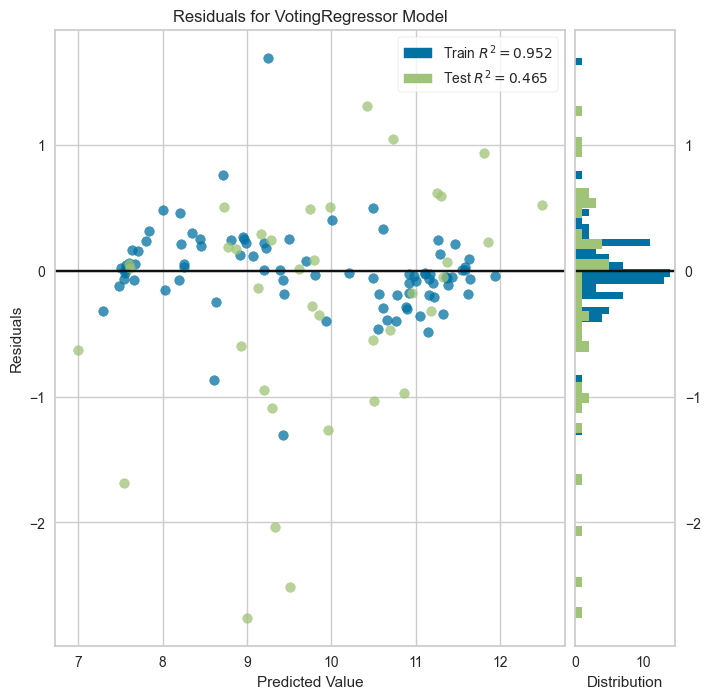

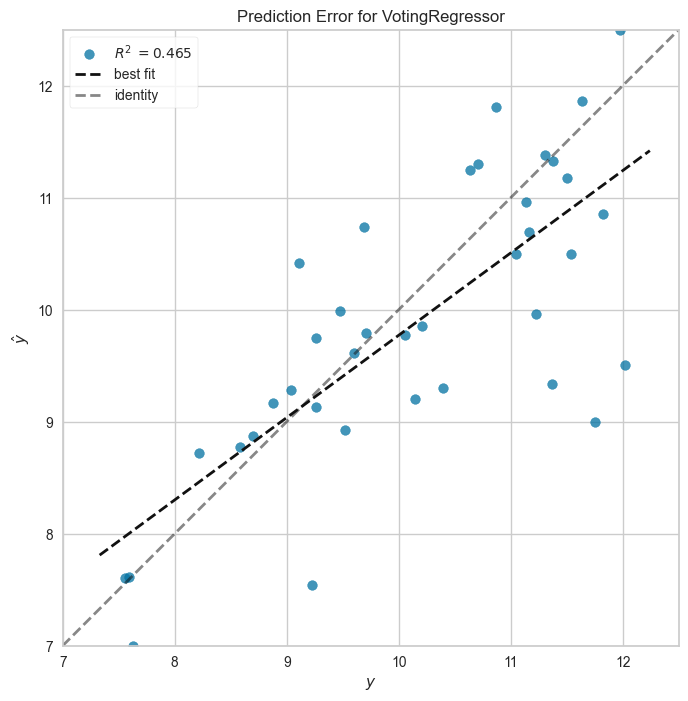

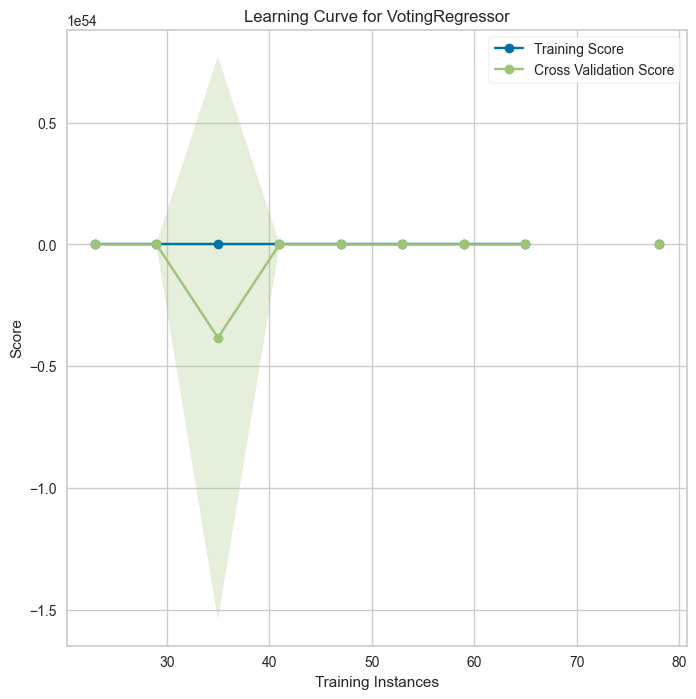

Gráfico de importancia de características para el modelo Ridge(alpha=3.3898330530859426, random_state=132400)...


<Figure size 800x800 with 0 Axes>

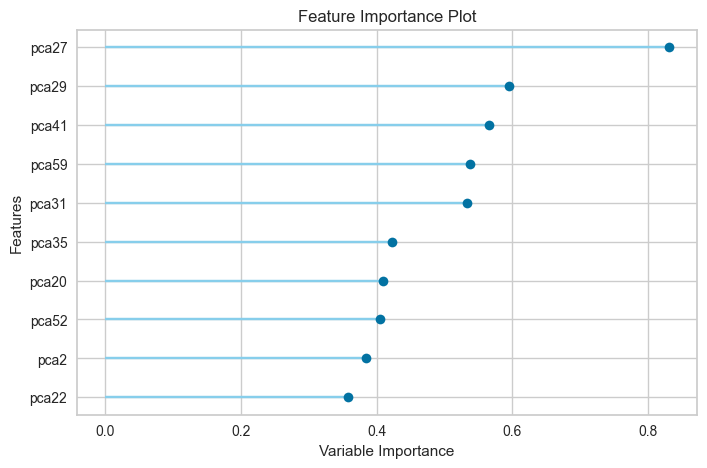

Gráfico de importancia de características para el modelo LinearRegression(n_jobs=-1)...


<Figure size 800x800 with 0 Axes>

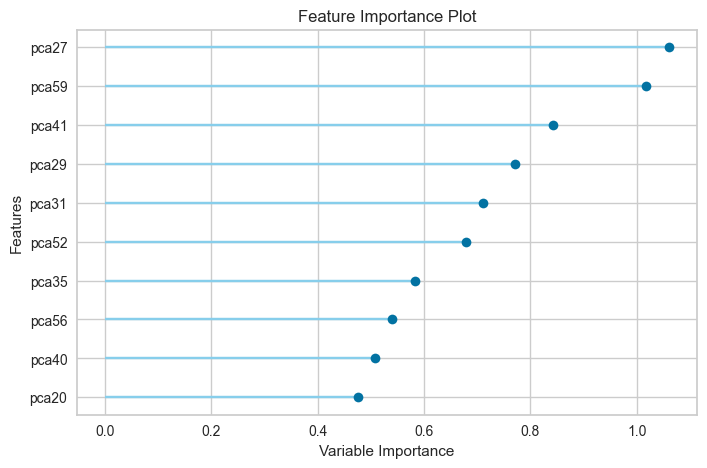

Gráfico de importancia de características para el modelo Lars(random_state=132400)...


<Figure size 800x800 with 0 Axes>

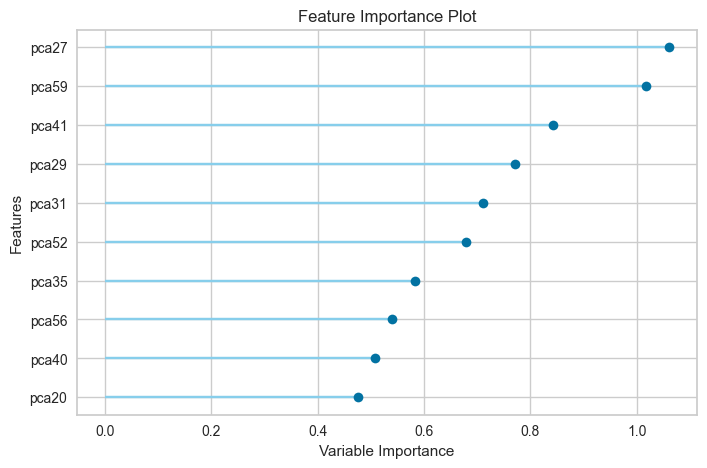

In [29]:
# Mostrar gráficos del mejor modelo con un tamaño de 8x8
print(F"Generando gráficos de diagnóstico para el modelo final{tuned_best_automl}")

# Gráfico de Residuos
plt.figure(figsize=(8, 8))
ax1 = plt.gca()
experiment.plot_model(tuned_best_automl, plot='residuals', plot_kwargs={'ax': ax1})


# Gráfico de Errores de Predicción
plt.figure(figsize=(8, 8))
ax2 = plt.gca()
experiment.plot_model(tuned_best_automl, plot='error', plot_kwargs={'ax': ax2})

# Gráfico de Errores de Predicción
plt.figure(figsize=(8, 8))
ax3 = plt.gca()
experiment.plot_model(tuned_best_automl, plot='learning', plot_kwargs={'ax': ax3})

# Gráfico de Importancia de Características este gráfico puede tardar un poco más en generarse y se es individual por modelo del ensamble

for i, model in enumerate(tuned_best_3):
    plt.figure(figsize=(8, 8))
    #ax = plt.gca()
    print(f"Gráfico de importancia de características para el modelo {model}...")
    experiment.plot_model(model, plot='feature', plot_kwargs={'ax': ax})
    #plt.title(f'Importancia de Características - Modelo {i+1}')
    #plt.show()




### Resultados del modelo final

#### Interpretación de Resultados del Modelo Blending
La tabla muestra el rendimiento del modelo blending (un tipo de VotingRegressor) evaluado mediante validación cruzada de 10 k-folds. Este modelo combina las predicciones de tres mejores modelos ajustados para intentar crear un predictor más robusto y preciso.

* Rendimiento Promedio (Fila "Mean")
R² (0.6173): En promedio, el modelo de blending explica aproximadamente el 62% de la variabilidad en la variable objetivo (pEC50). Comparado con el R² del mejor modelo individual (et con ~0.61).

* MAE (0.6530): En promedio, el error absoluto de las predicciones del modelo es de 0.65 unidades de pEC50. 
Análisis de la Estabilidad del Modelo (Fila "Std")
Alta Variabilidad en R² (Std = 0.2970): Este valor es relativamente alto e indica que el rendimiento del modelo no es muy estable. Varía considerablemente dependiendo de los datos con los que se entrena y evalúa.

* Análisis por Fold: Podemos ver esta inestabilidad claramente al comparar los resultados de los pliegues individuales:

* Mejor Rendimiento: En pliegues como el 7 y el 9, el modelo tuvo un rendimiento excelente, con un R² de 0.89 y 0.82, respectivamente.

* Peor Rendimiento: En el pliegue 4, el modelo falló por completo, obteniendo un R² negativo de -0.1959. Esto significa que en ese subconjunto de datos, el modelo fue peor que simplemente predecir el valor promedio.


* A pesar de ser bueno en promedio, su rendimiento puede ser  muy volátil. La alta desviación estándar, el mal desempeño en al menos un pliegue, nos sugiere que el modelo es sensible a ciertas características o subgrupos de datos.


### Finalizar el experimento
Finalmente entrenamos el mejor modelo con todos los datos disponibles para tener el modelo final listo para hacer predicciones.

In [17]:
# Finalizar el modelo (entrenar con todos los datos)
print("\nFinalizando el modelo...")
final_model = experiment.finalize_model(tuned_best_automl)



Finalizando el modelo...


### Guardado de los modelos y el contexto del experimento
Guardamos el estado completo del experimento, incluyendo todos los modelos y transformaciones, para poder cargarlo en el futuro sin necesidad de re-entrenar.

In [18]:
# Guardar el mejor modelo obtenido
print("\nGuardando el mejor modelo final...")
save_info = experiment.save_model(tuned_best_automl, ruta_mejor_modelo)
if save_info is not None:
    print(f"Mejor modelo final guardado en: {save_info[1]}")
else:
    print("No se pudo guardar el mejor modelo final.")

# Guardar modelo final (Entrenado con todos los datos)
print("\nGuardando el mejor modelo final...")
save_info = experiment.save_model(tuned_best_automl, ruta_mejor_modelo_final)
if save_info is not None:
    print(f"Mejor modelo final guardado en: {save_info[1]}")
else:
    print("No se pudo guardar el mejor modelo final.")    

# Guardar el experimento completo
print("\nGuardando el estado del experimento...")
save_info = experiment.save_experiment(ruta_experimento)
if save_info is not None:
    print(f"Estado del experimento guardado en: {save_info[1]}")
else:
    print("No se pudo guardar el estado del experimento.")    


Guardando el mejor modelo final...
Transformation Pipeline and Model Successfully Saved
Mejor modelo final guardado en: ..\models\pycaret\modelos_GLP1_pca\mejor_modelo.pkl

Guardando el mejor modelo final...
Transformation Pipeline and Model Successfully Saved
Mejor modelo final guardado en: ..\models\pycaret\modelos_GLP1_pca\mejor_modelo_final.pkl

Guardando el estado del experimento...
No se pudo guardar el estado del experimento.


### Predicción sobre Datos Desconocidos
Utilizamos nuestro mejor modelo finalizado para predecir la actividad (pEC50) de los péptidos del conjunto de datos df_desconocidos. Los resultados se guardan en un archivo Excel.

In [19]:
# Realizar predicciones sobre el dataframe de desconocidos
print(f"Realizando predicciones sobre {len(df_desconocidos)} péptidos desconocidos...")
predicciones_desconocidos = experiment.predict_model(final_model, data=df_desconocidos)
predicciones_conocidos = experiment.predict_model(tuned_best_automl, data=df_entrenamiento)

# Renombrar la columna de predicción para mayor claridad
predicciones_desconocidos.rename(columns={'prediction_label': 'pEC50_predicho'}, inplace=True)
predicciones_conocidos.rename(columns={'prediction_label': 'pEC50_predicho'}, inplace=True)

# Guardar las predicciones en un archivo CSV
predicciones_desconocidos.to_csv(ruta_resultados_prediccion)

print(f"\nPredicciones guardadas en: {ruta_resultados_prediccion}")


Realizando predicciones sobre 225 péptidos desconocidos...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.3561,0.3503,0.5919,0.8400,0.0545,0.0358



Predicciones guardadas en: ..\data\Predicciones_Peptidos_PCA_GLP1.csv


In [20]:
print("Muestra de las predicciones:")
display(predicciones_desconocidos)

Muestra de las predicciones:


,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,Moran_BEGF750103_lag3,Moran_BHAR880101_lag1,Moran_BHAR880101_lag2,Moran_BHAR880101_lag3,GAAC_alphatic,GAAC_aromatic,GAAC_postivecharge,GAAC_negativecharge,GAAC_uncharge,pEC50_predicho
ID,,,,,,,,,,,,,,,,,,,,,
AF-A0A060VXS0-F1,0.100000,0.0,0.066667,0.066667,0.033333,0.066667,0.033333,0.000000,0.066667,0.066667,...,0.131820,0.079774,-0.444248,0.023628,0.300000,0.133333,0.133333,0.133333,0.300000,8.013396
AF-A0A060VY52-F1,0.100000,0.0,0.066667,0.066667,0.033333,0.066667,0.033333,0.000000,0.066667,0.066667,...,0.080306,0.169242,-0.414974,0.015822,0.300000,0.133333,0.133333,0.133333,0.300000,8.477018
AF-A0A060WDT4-F1,0.100000,0.0,0.133333,0.000000,0.033333,0.066667,0.033333,0.000000,0.066667,0.100000,...,-0.005635,0.071809,-0.448173,-0.114346,0.333333,0.133333,0.100000,0.133333,0.300000,10.267008
AF-A0A087VEU7-F1,0.133333,0.0,0.033333,0.100000,0.033333,0.100000,0.033333,0.066667,0.033333,0.066667,...,0.162374,0.332517,-0.216526,-0.129492,0.400000,0.133333,0.100000,0.133333,0.233333,9.025815
AF-A0A087XPV4-F1,0.100000,0.0,0.133333,0.000000,0.066667,0.066667,0.033333,0.033333,0.100000,0.066667,...,-0.257055,0.121463,-0.334612,-0.370952,0.333333,0.100000,0.133333,0.133333,0.300000,11.879873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XP_027996892.1,0.133333,0.0,0.033333,0.166667,0.066667,0.033333,0.033333,0.000000,0.000000,0.100000,...,0.046593,0.128309,-0.261538,-0.287026,0.400000,0.133333,0.066667,0.200000,0.200000,12.032667
XP_028292477.1,0.100000,0.0,0.133333,0.000000,0.033333,0.066667,0.033333,0.000000,0.066667,0.066667,...,-0.003743,0.142639,-0.432684,0.029407,0.300000,0.133333,0.133333,0.133333,0.300000,9.257649
XP_029460758.1,0.100000,0.0,0.033333,0.166667,0.033333,0.100000,0.033333,0.033333,0.066667,0.066667,...,0.116491,0.305043,-0.329691,-0.089598,0.366667,0.133333,0.100000,0.200000,0.200000,8.749364


In [21]:
print("Muestra de las predicciones:")
display(predicciones_conocidos)

Muestra de las predicciones:


,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,Moran_BHAR880101_lag3,GAAC_alphatic,GAAC_aromatic,GAAC_postivecharge,GAAC_negativecharge,GAAC_uncharge,EC50_T2,EC50_LOG_T2,pEC50,pEC50_predicho
ID,,,,,,,,,,,,,,,,,,,,,
seq_pep1,0.033333,0.0,0.100000,0.100000,0.066667,0.066667,0.033333,0.000000,0.033333,0.066667,...,0.004513,0.200000,0.166667,0.133333,0.200000,0.300000,563.00,-9.25,9.249492,9.499854
seq_pep2,0.033333,0.0,0.100000,0.100000,0.066667,0.066667,0.033333,0.000000,0.033333,0.066667,...,0.037182,0.200000,0.166667,0.133333,0.200000,0.300000,552.00,-9.26,9.258060,9.748842
seq_pep3,0.034483,0.0,0.103448,0.068966,0.068966,0.034483,0.034483,0.000000,0.034483,0.068966,...,0.081687,0.172414,0.172414,0.137931,0.172414,0.344828,252.00,-9.60,9.598599,9.611594
seq_pep4,0.055556,0.0,0.083333,0.027778,0.055556,0.166667,0.027778,0.000000,0.027778,0.055556,...,0.156264,0.333333,0.138889,0.111111,0.111111,0.305556,6.03,-11.22,11.219683,11.153623
seq_pep5,0.066667,0.0,0.100000,0.066667,0.066667,0.066667,0.033333,0.000000,0.033333,0.066667,...,0.169722,0.233333,0.166667,0.133333,0.166667,0.300000,238.00,-9.62,9.623423,9.441461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq_pep121,0.033333,0.0,0.066667,0.100000,0.066667,0.100000,0.033333,0.033333,0.033333,0.066667,...,-0.101966,0.333333,0.133333,0.133333,0.166667,0.233333,9.62,-11.02,11.016825,10.920825
seq_pep122,0.033333,0.0,0.066667,0.100000,0.066667,0.100000,0.033333,0.033333,0.033333,0.100000,...,-0.186985,0.366667,0.133333,0.100000,0.166667,0.233333,7.94,-11.10,11.100180,10.918919
seq_pep123,0.033333,0.0,0.066667,0.100000,0.066667,0.100000,0.033333,0.033333,0.033333,0.066667,...,-0.117154,0.300000,0.133333,0.100000,0.166667,0.300000,29500.00,-7.53,7.530178,7.842367


### Analisis de la efectividad usando PCA

Para evaluar la efectividad del modelo, podemos utilizar PCA para reducir la dimensionalidad de los datos y visualizar cómo se distribuyen los péptidos conocidos y desconocidos en el espacio de características. Para ello, aplicamos PCA a ambos conjuntos de datos y graficamos los resultados en 3D.   


In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


pca = PCA(n_components=3)
principal_components_conocidos = pca.fit_transform( scaler.fit_transform(predicciones_conocidos.drop(columns=['pEC50', 'pEC50_predicho'])))
pca_df = pd.DataFrame(data=principal_components_conocidos, columns=['PC1', 'PC2', 'PC3'])
# Unir los componentes principales con la columna pEC50 usando el índice
pca_df = pca_df.set_index(predicciones_conocidos.index)
df_pca_conocidos = pd.concat([pca_df, predicciones_conocidos['pEC50']], axis=1)
#pca = PCA(n_components=2)

#pca = PCA(n_components=2)



In [23]:
pca = PCA(n_components=3)
principal_components_desconocidos = pca.fit_transform(scaler.fit_transform(predicciones_desconocidos.drop(columns=['pEC50_predicho'])))
pca_df_desconocidos = pd.DataFrame(data=principal_components_desconocidos, columns=['PC1', 'PC2', 'PC3'])

# Unir los componentes principales con la columna pEC50 usando el índice
pca_df_desconocidos = pca_df_desconocidos.set_index(predicciones_desconocidos.index)
df_pca_desconocidos = pd.concat([pca_df_desconocidos, predicciones_desconocidos['pEC50_predicho']], axis=1)
#pca = PCA(n_components=2)

#pca = PCA(n_components=2)

In [24]:
df_pca_conocidos

,PC1,PC2,PC3,pEC50
ID,,,,
seq_pep1,-2.993660,18.225391,-1.916723,9.249492
seq_pep2,-2.667434,17.973175,-2.388559,9.258060
seq_pep3,-2.147883,19.858402,-3.072251,9.598599
seq_pep4,11.119440,5.589553,-11.909291,11.219683
seq_pep5,-2.579339,16.634520,-3.552869,9.623423
...,...,...,...,...
seq_pep121,-8.737391,-1.960224,0.337615,11.016825
seq_pep122,-8.850081,-2.169047,1.099772,11.100180
seq_pep123,-5.731394,-2.478250,-0.526065,7.530178


In [25]:
df_pca_desconocidos

,PC1,PC2,PC3,pEC50_predicho
ID,,,,
AF-A0A060VXS0-F1,-4.457637,-6.343495,0.414749,8.013396
AF-A0A060VY52-F1,-5.401407,-7.672821,0.500304,8.477018
AF-A0A060WDT4-F1,-6.749963,-8.030167,1.768220,10.267008
AF-A0A087VEU7-F1,-6.521133,-4.686545,13.354608,9.025815
AF-A0A087XPV4-F1,-5.354795,-7.208714,-9.610354,11.879873
...,...,...,...,...
XP_027996892.1,-4.788784,2.695390,10.124041,12.032667
XP_028292477.1,-6.706235,-8.486123,-2.965951,9.257649
XP_029460758.1,-4.936451,-3.189922,7.405759,8.749364


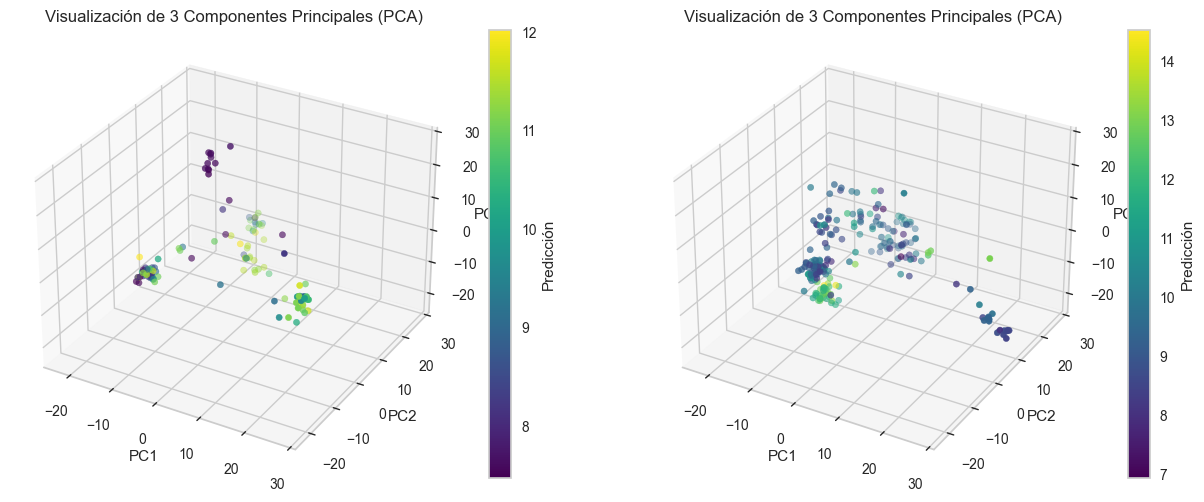

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Crear figura con dos subplots horizontales
fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_title('PCA 3D con Datos Conocidos')
ax2.set_title('PCA 3D con Datos Desconocidos')

plot_pca_3d(
    df_pca_conocidos,
    pc_x='PC1',
    pc_y='PC2',
    pc_z='PC3',
    color_by='pEC50',
    label='Predicción',
    xlim=(-25, 30),
    ylim=(-25, 30),
    zlim=(-25, 30),
   # title='PCA 3D con Predicciones',
    ax=ax1,
)

# Segundo subplot
plot_pca_3d(
    df_pca_desconocidos,
    pc_x='PC1',
    pc_y='PC2',
    pc_z='PC3',
    color_by='pEC50_predicho',
    label='Predicción',
    xlim=(-25, 30),
    ylim=(-25, 30),
    zlim=(-25, 30),
 #  title='PCA 3D con Predicciones'    ,
    ax=ax2,
)


# Mostrar ambos
plt.tight_layout()
plt.show()


Conclusiones



Concl